<a href="https://colab.research.google.com/github/akshayanant/nlp-google-colab/blob/main/object_detection_detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 25.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=71c9ebec9cd7a59da3b1e17a9292ba8bdd313d459f1e2e21fb604c8a2d8f7f81
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.8MB 647kB/s 
     |████████████████████████████████| 2.2MB 19.5MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.2.post20201111-cp36-none-any.whl size=44418 sha256=5b59eb1c797c85101c2e780ba4779942c651d0553edd625333601c8c7f068c42
  Stored in directory: /root/.cache/pip/wheels/70/d9/52/49a17f0d21e723c371c4a3f60138545e0a4163c5f7ff42c855
Successfully built fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import pandas as pd
import numpy as np



In [ ]:
!unzip './KK_Images.zip'

Archive:  ./KK_Images.zip
   creating: full_images/
  inflating: full_images/2_full_image.jpg  
  inflating: full_images/1_full_image.jpg  
  inflating: full_images/10_full_image.jpg  
  inflating: full_images/4_full_image.jpg  
  inflating: full_images/5_full_image.jpg  
  inflating: full_images/6_full_image.jpg  
  inflating: full_images/7_full_image.jpg  
  inflating: full_images/12_full_image.jpg  
  inflating: full_images/13_full_image.jpg  
  inflating: full_images/14_full_image.jpg  
  inflating: full_images/16_full_image.jpg  
  inflating: full_images/17_full_image.jpg  
  inflating: full_images/20_full_image.jpg  
  inflating: full_images/22_full_image.jpg  
  inflating: full_images/23_full_image.jpg  
  inflating: full_images/25_full_image.jpg  
  inflating: full_images/27_full_image.jpg  
  inflating: full_images/28_full_image.jpg  
  inflating: full_images/29_full_image.jpg  
  inflating: full_images/30_full_image.jpg  
  inflating: full_images/31_full_image.jpg  
  inflati

In [ ]:
data_frame = pd.read_csv('./bounding_boxes.csv')

In [ ]:
for idx, row in enumerate(data_frame.iterrows()):
    print(row[1][2])

455
338
351
346
452
333
422
335
368
422
440
361
463
286
286
286
394
338
345
477
351
286
322
342
381
363
381
392
330
440
345
464
385
428
406
378
345
396
470
435
367
327
347
428
345
439
336
409
351
428
320
379
371
385
419
349
348
386
345
315
399
411
411
365
482
450
511
323
470
383
516
366
387
359
382
496
412
406
286
343
355
341
286
286
354
331
415
390
342
441
336
333
428
355
363
468
447
339
374
437
350
411
404
441
379
286
286
423
447
444
377
353
352
521
345
392
450
460
440
375
468
461
394
338
345
417
456
466
412
338
452
337
383
367
358
430
320
348
474
359
345
427
439
345
436
329
409
345
357
340
389
388
509
286
477
469
448
344
479
454
483
434
338
286
360
465
493
354
464
368
336
414
425
374
286
457
465
406
403
286
345
370
438
440
328
437
457
424
375
405
426
499
345
445
429
362
475
463
332
415
403
356
369
487
370
358
379
364
353
494
351
393
407
286
417
450
445
496
428
410
488
360
466
362
357
348
368
449
477
416
418
435
466
436
347
325
337
458
413
446
334
379
437
329
398
338
404
286
452
337


In [ ]:
def show_anns(record) :

    img = cv2.imread(record['file_name'])
    visualizer = Visualizer(img)
    out = visualizer.draw_dataset_dict(record)
    cv2_imshow(out.get_image()[:, :, ::-1])

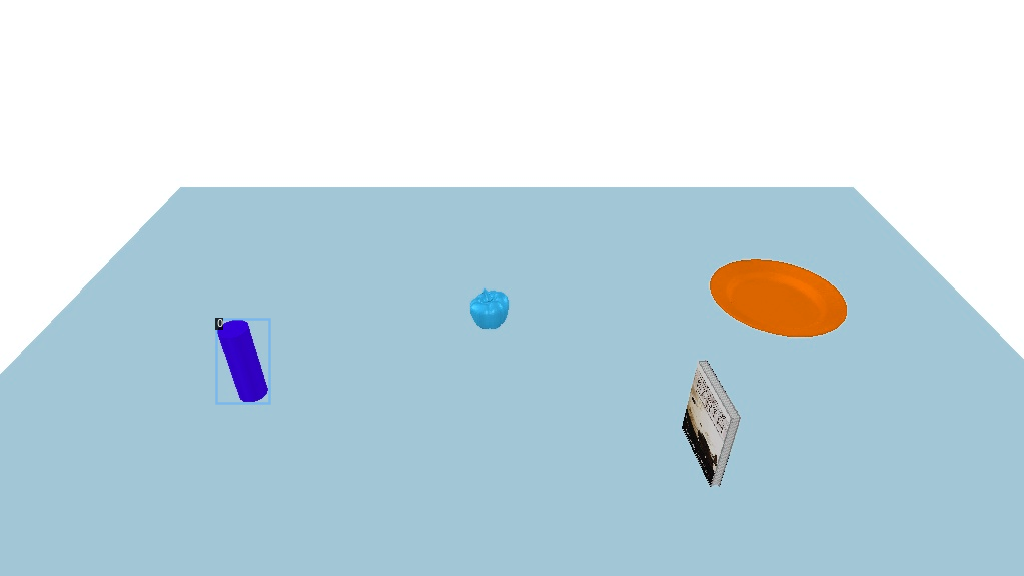

In [ ]:
show_anns(get_image_dicts()[200])

In [ ]:
DatasetCatalog.remove('full_image_train')

In [ ]:
from detectron2.structures import BoxMode

def get_image_dicts():

    dataset_dicts = []
    for idx, row in enumerate(data_frame.iterrows()):
        record = {}
        
        
        
        record["file_name"] = './full_images/' + str(row[1][0])
        record["image_id"] = idx
        record["height"] = 576
        record["width"] = 1024
      
        objs = []
        h = row

        obj = {
            "bbox": [int(row[1][1]),int(row[1][4]),int(row[1][3]),int(row[1][2])],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


DatasetCatalog.register("full_image_train", get_image_dicts)
MetadataCatalog.get("full_image_train").set(thing_classes=["seg_image"])
full_image_metadata = MetadataCatalog.get("full_image_train")

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("full_image_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR 0.00025 
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/16 04:48:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.


[11/16 04:48:12 d2.engine.train_loop]: Starting training from iteration 0
[11/16 04:48:23 d2.utils.events]:  eta: 0:08:50  iter: 19  total_loss: 0.9301  loss_cls: 0.7618  loss_box_reg: 0.1479  loss_rpn_cls: 0.002757  loss_rpn_loc: 0.002586  time: 0.5448  data_time: 0.0159  lr: 4.9953e-06  max_mem: 3289M
[11/16 04:48:34 d2.utils.events]:  eta: 0:08:54  iter: 39  total_loss: 0.8148  loss_cls: 0.6373  loss_box_reg: 0.1099  loss_rpn_cls: 0.01501  loss_rpn_loc: 0.002747  time: 0.5512  data_time: 0.0046  lr: 9.9902e-06  max_mem: 3289M
[11/16 04:48:45 d2.utils.events]:  eta: 0:08:41  iter: 59  total_loss: 0.6023  loss_cls: 0.4395  loss_box_reg: 0.1543  loss_rpn_cls: 0.0008207  loss_rpn_loc: 0.001051  time: 0.5492  data_time: 0.0054  lr: 1.4985e-05  max_mem: 3289M
[11/16 04:48:56 d2.utils.events]:  eta: 0:08:30  iter: 79  total_loss: 0.4823  loss_cls: 0.3032  loss_box_reg: 0.1597  loss_rpn_cls: 0.0004334  loss_rpn_loc: 0.001929  time: 0.5494  data_time: 0.0049  lr: 1.998e-05  max_mem: 3289M
[1

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1   # set a custom testing threshold
predictor = DefaultPredictor(cfg)



In [ ]:
cfg = get_cfg()
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ('full_image_train',)
predictor = DefaultPredictor(cfg)

Skip loading parameter 'proposal_generator.rpn_head.conv.weight' to the model due to incompatible shapes: (256, 256, 3, 3) in the checkpoint but (1024, 1024, 3, 3) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.conv.bias' to the model due to incompatible shapes: (256,) in the checkpoint but (1024,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (15, 1024, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (15,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible s

In [ ]:
def infer(img_file,grayscale = False) :

    img = cv2.imread(img_file)
    if grayscale : 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img2 = np.zeros_like(img)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray
        img = img2
    pred = predictor(img)
    print(pred)
    v = Visualizer(img,metadata=balloon_metadata)
    out = v.draw_instance_predictions(pred["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

{'instances': Instances(num_instances=4, image_height=576, image_width=1024, fields=[pred_boxes: Boxes(tensor([[483.8425, 262.9497, 529.4432, 335.1476],
        [801.4200, 320.5970, 855.8992, 404.8501],
        [177.0105, 301.7737, 331.2545, 401.5248],
        [626.7403, 295.9662, 666.3635, 333.8781]], device='cuda:0')), scores: tensor([0.5627, 0.5271, 0.1379, 0.1355], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])}


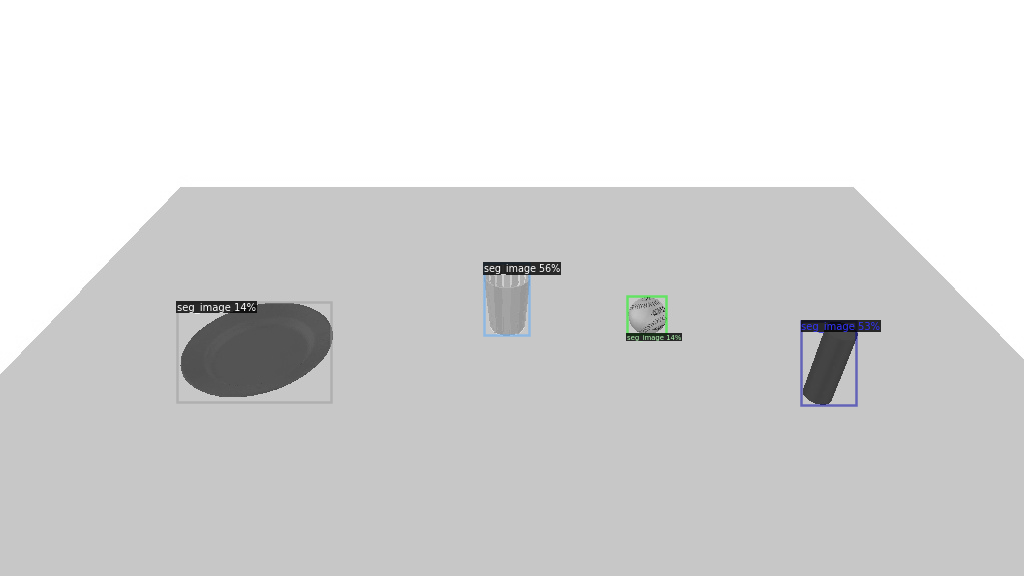

In [ ]:
infer('./full_images/200_full_image.jpg',grayscale=True)

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
